# Autoencoder Training
Here we train write to pipeline to train the autoencoder for the task

TODO (Things to try)
1) Make seperate autoencoders for numerical, categorical, and sequential data

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

### Importing the data

In [2]:
autoencoder_train = np.load("data/Autoencoder_processed/Autoencoder_train.npy")
autoencoder_test = np.load("data/Autoencoder_processed/Autoencoder_test.npy")

print(f"Train: {autoencoder_train.shape}\nTest: {autoencoder_test.shape}")

Train: (1647, 66)
Test: (412, 66)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Defining the Model

In [9]:
PATH_TO_MODELS = "models/AutoEncoder"
MODEL_NAME = "AutoEn_66_18_ReLU_10"  # InputSize_OutputSize_ActivationFunction_DropoutP*100

class Encoder(nn.Module):
    def __init__(self, input_columns=66, output_size=18, hidden_size=33, dropout_p=0.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ffn = nn.Sequential(
            nn.Linear(input_columns, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ffn(x)
    
class Decoder(nn.Module):
    def __init__(self, input_columns=18, output_size=66, hidden_size=33, dropout_p=0.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ffn = nn.Sequential(
            nn.Linear(input_columns, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ffn(x)

class AutoEncoder(nn.Module):
    def __init__(self, input_columns=66, embedding_size=18, hidden_size=33, dropout_p=0.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = Encoder(input_columns=input_columns, output_size=embedding_size, hidden_size=hidden_size, dropout_p=dropout_p)
        self.decoder = Decoder(input_columns=embedding_size, output_size=input_columns, hidden_size=hidden_size, dropout_p=dropout_p)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embeddings = self.encoder(x)
        return self.decoder(embeddings)


In [5]:
class Horse_Health_AutoEncoder_Dataset(Dataset):
    def __init__(self, x: np.ndarray):
        x_tensor = torch.from_numpy(x)
        self.X = x_tensor.to(device)
        self.y = x_tensor.to(device)
        self.length = x.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
def create_dataloader(X, batch_size=128):
    """Returns a torch dataloader for the given dataset and batch_size"""
    dataset = Horse_Health_AutoEncoder_Dataset(X)
    dataloaders = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    return dataloaders

### Training Pipeline

In [6]:
class EarlyStopper:
    """Implements Early Stoppage of training when there is not progress in validation set"""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        y = y.type(torch.FloatTensor).to(device)
        X = X.type(torch.FloatTensor).to(device)
        pred = model(X)
        # print(f"pred size = {str(pred.size())}")
        # print(f"y size = {y.size()}")
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    
    return train_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.FloatTensor).to(device)
            X = X.type(torch.FloatTensor).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    
    test_loss /= num_batches
    return test_loss

def train(train_dataloader: DataLoader, validation_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, epochs=100, patience=5):
    early_stopper = EarlyStopper(patience=patience)
    tr_loss = []
    va_loss = []
    for t in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        valid_loss = test_loop(validation_dataloader, model, loss_fn)

        tr_loss.append(train_loss)
        va_loss.append(valid_loss)

        print(f"Epoch {t+1}: Train_loss: {train_loss:>8f}, Validation_loss: {valid_loss:>8f}")

        if (t + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{PATH_TO_MODELS}/{MODEL_NAME}_epoch_{t+1}.pt")
            torch.save(model.encoder.state_dict(), f"{PATH_TO_MODELS}/{MODEL_NAME}_justEncoder_epoch_{t+1}.pt")

        if early_stopper.early_stop(valid_loss):
            print("Early Stopping Cutoff!")
            break

    return tr_loss, va_loss

In [11]:
# Create the dataloaders
train_dataloader = create_dataloader(batch_size=128, X=autoencoder_train)
valid_dataloader = create_dataloader(batch_size=128, X=autoencoder_test)

# Create the model
model = AutoEncoder()
model.to(device)

# Define the optimizer and loss function
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Train the model
train_loss, valid_loss = train(train_dataloader=train_dataloader, validation_dataloader=valid_dataloader,
                                                               model=model, loss_fn=loss_fn, optimizer=optimizer, epochs=100, patience=10)

100%|██████████| 13/13 [00:00<00:00, 681.84it/s]


Epoch 1: Train_loss: 0.289236, Validation_loss: 0.283701


100%|██████████| 13/13 [00:00<00:00, 630.66it/s]


Epoch 2: Train_loss: 0.243780, Validation_loss: 0.256772


100%|██████████| 13/13 [00:00<00:00, 289.85it/s]


Epoch 3: Train_loss: 0.222103, Validation_loss: 0.238360


100%|██████████| 13/13 [00:00<00:00, 991.22it/s]


Epoch 4: Train_loss: 0.206994, Validation_loss: 0.294901


100%|██████████| 13/13 [00:00<00:00, 964.55it/s]


Epoch 5: Train_loss: 0.195859, Validation_loss: 0.216795


100%|██████████| 13/13 [00:00<00:00, 933.76it/s]


Epoch 6: Train_loss: 0.189843, Validation_loss: 0.214476


100%|██████████| 13/13 [00:00<00:00, 995.64it/s]


Epoch 7: Train_loss: 0.188569, Validation_loss: 0.208589


100%|██████████| 13/13 [00:00<00:00, 1113.21it/s]


Epoch 8: Train_loss: 0.184269, Validation_loss: 0.198740


100%|██████████| 13/13 [00:00<00:00, 952.50it/s]


Epoch 9: Train_loss: 0.182822, Validation_loss: 0.199840


100%|██████████| 13/13 [00:00<00:00, 959.27it/s]


Epoch 10: Train_loss: 0.179246, Validation_loss: 0.191717


100%|██████████| 13/13 [00:00<00:00, 1015.55it/s]


Epoch 11: Train_loss: 0.177463, Validation_loss: 0.195296


100%|██████████| 13/13 [00:00<00:00, 1093.45it/s]


Epoch 12: Train_loss: 0.176235, Validation_loss: 0.191154


100%|██████████| 13/13 [00:00<00:00, 864.49it/s]


Epoch 13: Train_loss: 0.173454, Validation_loss: 0.188397


100%|██████████| 13/13 [00:00<00:00, 1049.08it/s]


Epoch 14: Train_loss: 0.173438, Validation_loss: 0.188443


100%|██████████| 13/13 [00:00<00:00, 947.88it/s]


Epoch 15: Train_loss: 0.172547, Validation_loss: 0.191543


100%|██████████| 13/13 [00:00<00:00, 944.29it/s]


Epoch 16: Train_loss: 0.172850, Validation_loss: 0.186946


100%|██████████| 13/13 [00:00<00:00, 999.16it/s]


Epoch 17: Train_loss: 0.170002, Validation_loss: 0.187551


100%|██████████| 13/13 [00:00<00:00, 850.23it/s]


Epoch 18: Train_loss: 0.168628, Validation_loss: 0.185031


100%|██████████| 13/13 [00:00<00:00, 860.29it/s]


Epoch 19: Train_loss: 0.169315, Validation_loss: 0.188204


100%|██████████| 13/13 [00:00<00:00, 697.68it/s]


Epoch 20: Train_loss: 0.170025, Validation_loss: 0.182284


100%|██████████| 13/13 [00:00<00:00, 739.43it/s]


Epoch 21: Train_loss: 0.168214, Validation_loss: 0.187192


100%|██████████| 13/13 [00:00<00:00, 806.85it/s]


Epoch 22: Train_loss: 0.168017, Validation_loss: 0.183517


100%|██████████| 13/13 [00:00<00:00, 965.49it/s]


Epoch 23: Train_loss: 0.166545, Validation_loss: 0.189503


100%|██████████| 13/13 [00:00<00:00, 778.44it/s]


Epoch 24: Train_loss: 0.168032, Validation_loss: 0.203680


100%|██████████| 13/13 [00:00<00:00, 919.90it/s]


Epoch 25: Train_loss: 0.168196, Validation_loss: 0.183844


100%|██████████| 13/13 [00:00<00:00, 988.43it/s]


Epoch 26: Train_loss: 0.164610, Validation_loss: 0.182719


100%|██████████| 13/13 [00:00<00:00, 1025.08it/s]


Epoch 27: Train_loss: 0.164934, Validation_loss: 0.184475


100%|██████████| 13/13 [00:00<00:00, 1031.75it/s]


Epoch 28: Train_loss: 0.163972, Validation_loss: 0.187174


100%|██████████| 13/13 [00:00<00:00, 1010.11it/s]


Epoch 29: Train_loss: 0.164321, Validation_loss: 0.183614


100%|██████████| 13/13 [00:00<00:00, 968.70it/s]


Epoch 30: Train_loss: 0.164493, Validation_loss: 0.179490


100%|██████████| 13/13 [00:00<00:00, 1050.82it/s]


Epoch 31: Train_loss: 0.163975, Validation_loss: 0.179087


100%|██████████| 13/13 [00:00<00:00, 997.07it/s]


Epoch 32: Train_loss: 0.160578, Validation_loss: 0.176949


100%|██████████| 13/13 [00:00<00:00, 964.55it/s]


Epoch 33: Train_loss: 0.156928, Validation_loss: 0.176873


100%|██████████| 13/13 [00:00<00:00, 1025.43it/s]


Epoch 34: Train_loss: 0.154152, Validation_loss: 0.170712


100%|██████████| 13/13 [00:00<00:00, 912.16it/s]


Epoch 35: Train_loss: 0.154052, Validation_loss: 0.239339


100%|██████████| 13/13 [00:00<00:00, 705.90it/s]


Epoch 36: Train_loss: 0.155398, Validation_loss: 0.171813


100%|██████████| 13/13 [00:00<00:00, 966.93it/s]


Epoch 37: Train_loss: 0.154714, Validation_loss: 0.166952


100%|██████████| 13/13 [00:00<00:00, 806.10it/s]


Epoch 38: Train_loss: 0.152759, Validation_loss: 0.173328


100%|██████████| 13/13 [00:00<00:00, 934.13it/s]


Epoch 39: Train_loss: 0.153748, Validation_loss: 0.170831


100%|██████████| 13/13 [00:00<00:00, 910.10it/s]


Epoch 40: Train_loss: 0.153647, Validation_loss: 0.175162


100%|██████████| 13/13 [00:00<00:00, 933.65it/s]


Epoch 41: Train_loss: 0.153289, Validation_loss: 0.170072


100%|██████████| 13/13 [00:00<00:00, 953.85it/s]


Epoch 42: Train_loss: 0.152445, Validation_loss: 0.173040


100%|██████████| 13/13 [00:00<00:00, 950.77it/s]


Epoch 43: Train_loss: 0.152415, Validation_loss: 0.236483


100%|██████████| 13/13 [00:00<00:00, 1057.59it/s]


Epoch 44: Train_loss: 0.153338, Validation_loss: 0.172272


100%|██████████| 13/13 [00:00<00:00, 898.17it/s]


Epoch 45: Train_loss: 0.151918, Validation_loss: 0.175288


100%|██████████| 13/13 [00:00<00:00, 896.62it/s]


Epoch 46: Train_loss: 0.152870, Validation_loss: 0.173112


100%|██████████| 13/13 [00:00<00:00, 995.64it/s]

Epoch 47: Train_loss: 0.152294, Validation_loss: 0.171398
Early Stopping Cutoff!


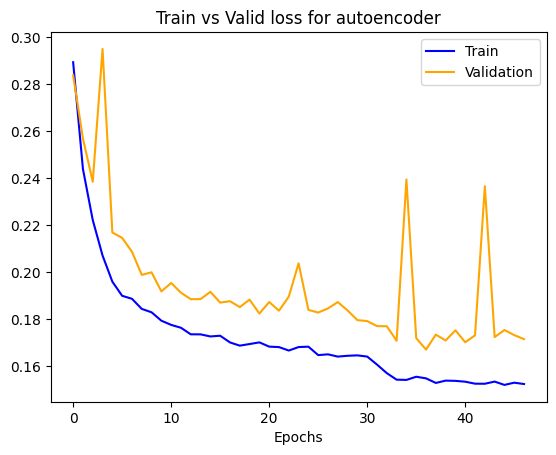

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_loss, color='blue', label='Train')
plt.plot(valid_loss, color='orange', label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.title("Train vs Valid loss for autoencoder")
plt.show()

### Testing the checkpoints

In [18]:
model_auto_enc = AutoEncoder()
model_auto_enc.load_state_dict(torch.load("models/AutoEncoder/AutoEn_66_18_ReLU_10_epoch_45.pt"))
model_auto_enc.eval()

AutoEncoder(
  (encoder): Encoder(
    (ffn): Sequential(
      (0): Linear(in_features=66, out_features=33, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=33, out_features=18, bias=True)
      (4): ReLU()
    )
  )
  (decoder): Decoder(
    (ffn): Sequential(
      (0): Linear(in_features=18, out_features=33, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=33, out_features=66, bias=True)
      (4): ReLU()
    )
  )
)

In [19]:
model_just_encoder = Encoder()
model_just_encoder.load_state_dict(torch.load("models/AutoEncoder/AutoEn_66_18_ReLU_10_justEncoder_epoch_45.pt"))
model_just_encoder.eval()

Encoder(
  (ffn): Sequential(
    (0): Linear(in_features=66, out_features=33, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=33, out_features=18, bias=True)
    (4): ReLU()
  )
)

In [26]:
# Taking a random data sample
sample = autoencoder_test[0:1]
sample_tensor = torch.from_numpy(sample).type(torch.FloatTensor)
model_auto_enc.encoder(sample_tensor)

tensor([[0.1810, 2.2257, 1.3829, 0.0681, 0.0000, 0.0000, 0.0000, 1.1273, 1.8606,
         2.0901, 0.4980, 0.6612, 0.3558, 1.4307, 1.3964, 0.0000, 1.1784, 2.1274]],
       grad_fn=<ReluBackward0>)

In [25]:
model_just_encoder(sample_tensor)

tensor([[0.1810, 2.2257, 1.3829, 0.0681, 0.0000, 0.0000, 0.0000, 1.1273, 1.8606,
         2.0901, 0.4980, 0.6612, 0.3558, 1.4307, 1.3964, 0.0000, 1.1784, 2.1274]],
       grad_fn=<ReluBackward0>)

So to get the encoder checkpoints either method is fine